In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import time
from itertools import product


# Initial Setup

In [ ]:
# Load data
df = pd.read_csv('titik_semprotan.csv')
ids = df['id'].tolist()
locations = df[['x', 'y']].values

In [3]:
# --- 0) Caching jarak antar titik (tetap boleh dipakai on-demand) ---
distance_cache = {}

# id -> index ke array locations (diasumsikan locations selaras dengan ids)
id2idx = {i: k for k, i in enumerate(ids)}

def get_weight(i, j):
    key = (i, j)
    if key in distance_cache:
        return distance_cache[key]
    ii, jj = id2idx[i], id2idx[j]
    dx = locations[ii][0] - locations[jj][0]
    dy = locations[ii][1] - locations[jj][1]
    d = float(np.hypot(dx, dy))
    distance_cache[(i, j)] = d
    distance_cache[(j, i)] = d
    return d

In [4]:
# --- 1) Nodes deterministik (order-preserving unique), bukan set(ids) ---
# kalau ids sudah unik, ini sama dengan ids[:]
nodes = list(dict.fromkeys(ids))     # menjaga urutan, menghilangkan duplikat
N = len(nodes)

# mapping ID -> index baris/kolom di D
idx = {node: k for k, node in enumerate(nodes)}

# --- 2) Bangun matrix koordinat sesuai urutan nodes ---
# (akses locations tetap via id2idx yang dibangun dari ids)
coords = np.empty((N, 2), dtype=np.float64)
for k, node in enumerate(nodes):
    ii = id2idx[node]
    coords[k, 0] = locations[ii][0]
    coords[k, 1] = locations[ii][1]

# --- 3) Vectorized distance matrix (cepat & konsisten) ---
diff = coords[:, None, :] - coords[None, :, :]     # shape (N, N, 2)
D = np.sqrt((diff * diff).sum(axis=2))              # shape (N, N), float64
np.fill_diagonal(D, 0.0)                            # diagonal nol

In [5]:
# Opsional: pakai matrix D + idx (lebih cepat, no cache lookup)
def total_distance(tour):
    L = len(tour)
    if L < 2:
        return 0.0
    s = 0.0
    for i in range(L - 1):
        s += D[idx[tour[i]], idx[tour[i+1]]]
    s += D[idx[tour[-1]], idx[tour[0]]]
    return float(s)

In [6]:
def split_ids(ids, num_vehicles):
    ids_copy = ids[:]
    random.shuffle(ids_copy)
    return [ids_copy[i::num_vehicles] for i in range(num_vehicles)]

# ORTOOLS for Benchmarking

In [7]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

SCALE = 1000  # pilih 10^k sesuai presisi jarakmu

def create_data_model():
    # matrix terindeks 0..N-1 sesuai urutan `ids`
    matrix = [[int(round(SCALE * get_weight(i, j))) for j in ids] for i in ids]
    return {
        'distance_matrix': matrix,
        'num_vehicles': 1,  # hanya 1 kendaraan
        'depot': 0,  # index 0 <-> ids[0]
    }

def solve_vrp(timeout_s=60):
    data = create_data_model()
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'],
                                           data['depot'])
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        f = manager.IndexToNode(from_index)
        t = manager.IndexToNode(to_index)
        return data['distance_matrix'][f][t]  # sudah integer bertingkat SCALE

    transit_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_idx)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_parameters.time_limit.seconds = timeout_s

    solution = routing.SolveWithParameters(search_parameters)
    if not solution:
        print("No solution found!")
        return None, float('inf')

    routes = []
    # Hanya ada 1 kendaraan, jadi hanya perlu satu rute
    vehicle_id = 0
    index = routing.Start(vehicle_id)
    route = []
    while not routing.IsEnd(index):
        route.append(ids[manager.IndexToNode(index)])
        index = solution.Value(routing.NextVar(index))
    route.append(ids[manager.IndexToNode(index)])  # kembali ke depot
    routes.append(route)

    # cost solver (skala -> float)
    cost_scaled = solution.ObjectiveValue()
    cost_float = cost_scaled / SCALE
    return routes, cost_float

# Contoh pemakaian:
routes, cost = solve_vrp(timeout_s=40)
print("Total cost:", cost)
for i, route in enumerate(routes):
    print(f"Rute kendaraan {i+1}:", route)

Total cost: 1216.607
Rute kendaraan 1: [1, 130, 101, 50, 43, 123, 67, 129, 21, 124, 26, 11, 103, 42, 4, 95, 133, 111, 63, 23, 107, 34, 72, 40, 81, 37, 96, 112, 132, 62, 93, 15, 106, 110, 54, 29, 52, 117, 10, 80, 51, 27, 59, 125, 82, 3, 90, 114, 46, 45, 61, 126, 100, 131, 98, 48, 127, 32, 92, 12, 70, 120, 25, 64, 113, 104, 39, 74, 66, 2, 75, 119, 13, 89, 33, 68, 118, 19, 121, 44, 128, 58, 18, 78, 38, 53, 135, 8, 84, 69, 116, 41, 108, 6, 87, 122, 28, 109, 73, 57, 134, 14, 102, 83, 31, 97, 5, 91, 36, 105, 24, 94, 49, 9, 99, 56, 17, 35, 79, 22, 86, 7, 65, 85, 16, 60, 20, 77, 88, 76, 47, 115, 30, 55, 71, 1]


# Lovebird Initial Algorithm

In [8]:
def swap_two(tour, i, j): # red
    new = tour[:]
    if j - i < 4:
        return interchange(new, i, j)

    mid = new[i:j+1]
    k = len(mid) // 2
    seg1 = mid[:k]
    seg2 = mid[k:]
    new[i:i+k] = seg2
    new[i+k:j+1] = seg1
    return new

def flip(tour, i, j): # peach
    new = tour[:]
    new[i:j+1] = reversed(new[i:j+1])
    return new

def interchange(tour, i, j): # green
    new = tour[:]
    new[i], new[j] = new[j], new[i]
    return new

def slide(tour, i, j): # yellow
    new = tour[:]
    city = new.pop(i)
    new.insert(j, city)
    return new

def guided_swap(tour, i, j): # blue
    new = flip(tour, i, j)
    return interchange(new, i, j)

def scramble(tour): # gray
    new = tour[:]
    random.shuffle(new)
    return new

In [9]:
# Fungsi untuk RouletteWheel (untuk pemilihan titik secara probabilistik)
def roulette_wheel(population, fitness):
    total_fitness = sum(fitness)
    selection = random.uniform(0, total_fitness)
    current_sum = 0
    for i, individual in enumerate(population):
        current_sum += fitness[i]
        if current_sum >= selection:
            return individual
    return population[-1]  # fallback jika tidak ada yang terpilih

In [10]:
def lovebird_algorithm(maxGeneration, popSize):
    EPS = 1e-12

    # -- gunakan split_ids global agar konsisten (bukan inner re-def) --
    population = [split_ids(ids, 1) for _ in range(popSize)]  # num_vehicles sudah di-set 1

    # biaya awal populasi (hitung SEKALI)
    pop_costs = [sum(total_distance(r) for r in ind) for ind in population]

    # best awal
    best_idx = min(range(popSize), key=lambda i: pop_costs[i])
    best_solution = [r[:] for r in population[best_idx]]
    best_fitness = pop_costs[best_idx]
    history = [best_fitness]

    for g in range(maxGeneration):
        # -------- selection fitness (SEKALI per generasi) --------
        fitness = [1.0/c if c > 0 else 1e9 for c in pop_costs]

        new_population = []
        new_costs = []

        for _ in range(popSize):
            # roulette selection (pakai fitness yg sudah dihitung)
            individual = roulette_wheel(population, fitness)

            # salin ringan (bukan deepcopy) → list of routes
            T = [r[:] for r in individual]

            # ---------- mutation ----------
            route = T[0]  # hanya ada satu kendaraan
            L = len(route)
            if L > 1:
                # simpan rute & biaya sebelum mutasi (untuk pembanding)
                old_route = route[:] 
                old_cost  = total_distance(old_route)

                # lakukan mutasi kandidat
                if random.random() < 0.9:
                    i_idx, j_idx = sorted(random.sample(range(L), 2))
                    op = random.choice([1, 2, 3, 4, 5])
                    if op == 1:
                        cand_route = swap_two(route, i_idx, j_idx)
                    elif op == 2:
                        cand_route = flip(route, i_idx, j_idx)
                    elif op == 3:
                        cand_route = interchange(route, i_idx, j_idx)
                    elif op == 4:
                        cand_route = slide(route, i_idx, j_idx)
                    else:
                        cand_route = guided_swap(route, i_idx, j_idx)
                else:
                    cand_route = scramble(route)

                # ---------- PEMBANDING: terima mutasi hanya jika lebih baik ----------
                new_cost = total_distance(cand_route)
                if new_cost < old_cost - EPS:
                    T[0] = cand_route  # terima mutasi
                else:
                    T[0] = old_route    # tolak mutasi (revert)

            # ---------- local search stacking (lebih hemat dengan delta) ----------
            # hitung biaya total kandidat sekali di awal
            route_costs = [total_distance(r) for r in T]
            total_cost = sum(route_costs)

            improved_outer = True
            while improved_outer:
                improved_outer = False

                # ---- SWAP (circular) first-improvement ----
                made_swap = True
                while made_swap:
                    made_swap = False
                    r = T[0]  # hanya ada satu kendaraan
                    L = len(r)
                    if L <= 2: 
                        continue
                    accepted = False
                    i = 0
                    while i < L - 1 and not accepted:
                        j = i + 1
                        while j < L and not accepted:
                            a_idx, c_idx = i, j
                            aL = r[(a_idx - 1) % L]
                            a  = r[a_idx]
                            b  = r[(a_idx + 1) % L]
                            cL = r[(c_idx - 1) % L]
                            c  = r[c_idx]
                            d  = r[(c_idx + 1) % L]

                            adjacent = (c_idx == a_idx + 1) or (a_idx == 0 and c_idx == L - 1)
                            if adjacent:
                                if c_idx == a_idx + 1:
                                    old = D[idx[aL], idx[a]] + D[idx[a], idx[c]] + D[idx[c], idx[d]]
                                    new = D[idx[aL], idx[c]] + D[idx[c], idx[a]] + D[idx[a], idx[d]]
                                else:
                                    old = D[idx[cL], idx[c]] + D[idx[c], idx[a]] + D[idx[a], idx[b]]
                                    new = D[idx[cL], idx[a]] + D[idx[a], idx[c]] + D[idx[c], idx[b]]
                            else:
                                old = (D[idx[aL], idx[a]] + D[idx[a], idx[b]] +
                                       D[idx[cL], idx[c]] + D[idx[c], idx[d]])
                                new = (D[idx[aL], idx[c]] + D[idx[c], idx[b]] +
                                       D[idx[cL], idx[a]] + D[idx[a], idx[d]])
                            delta = new - old
                            if delta < -EPS:
                                r[a_idx], r[c_idx] = r[c_idx], r[a_idx]
                                route_costs[0] += delta
                                total_cost += delta
                                made_swap = True
                                improved_outer = True
                                accepted = True
                            else:
                                j += 1
                        if not accepted:
                            i += 1
                    if made_swap:
                        break  # restart dari v=0

                # ---- 2-OPT / FLIP (circular) first-improvement ----
                made_flip = True
                while made_flip:
                    made_flip = False
                    r = T[0]  # hanya ada satu kendaraan
                    L = len(r)
                    if L <= 2: 
                        continue
                    accepted = False
                    i = 0
                    while i < L - 1 and not accepted:
                        j = i + 1
                        while j < L and not accepted:
                            if i == 0 and j == L - 1:
                                j += 1
                                continue
                            ap = r[(i - 1) % L]
                            a  = r[i]
                            c  = r[j]
                            dn = r[(j + 1) % L]
                            old = D[idx[ap], idx[a]] + D[idx[c], idx[dn]]
                            new = D[idx[ap], idx[c]] + D[idx[a], idx[dn]]
                            delta = new - old
                            if delta < -EPS:
                                r[i:j+1] = reversed(r[i:j+1])
                                route_costs[0] += delta
                                total_cost += delta
                                made_flip = True
                                improved_outer = True
                                accepted = True
                            else:
                                j += 1
                        if not accepted:
                            i += 1
                    if made_flip:
                        break  # restart dari v=0

            new_population.append(T)
            new_costs.append(total_cost)

        # -------- elitism: update best dari kandidat baru --------
        gen_best_idx = min(range(popSize), key=lambda i: new_costs[i])
        if new_costs[gen_best_idx] < best_fitness - EPS:
            best_fitness = new_costs[gen_best_idx]
            best_solution = [r[:] for r in new_population[gen_best_idx]]

        # siapkan generasi berikutnya
        population = new_population
        pop_costs  = new_costs
        history.append(best_fitness)

    return best_solution, best_fitness, history

In [11]:
# Contoh penggunaan lovebird_algorithm
best_routes, best_cost, history = lovebird_algorithm(maxGeneration=1, popSize=1)
print("Total cost:", best_cost)
for i, route in enumerate(best_routes):
    print(f"Rute kendaraan {i+1}:", route)

Total cost: 1333.6078950166345
Rute kendaraan 1: [94, 24, 105, 36, 91, 5, 97, 31, 102, 14, 134, 57, 73, 109, 28, 122, 87, 6, 41, 108, 121, 44, 128, 114, 19, 118, 68, 33, 89, 13, 119, 75, 74, 39, 104, 64, 25, 120, 70, 113, 12, 92, 32, 66, 127, 2, 48, 98, 131, 100, 126, 61, 45, 46, 90, 3, 82, 125, 59, 27, 51, 80, 10, 117, 52, 110, 54, 29, 133, 95, 4, 42, 103, 11, 26, 111, 63, 23, 107, 34, 72, 40, 106, 81, 15, 93, 62, 37, 96, 132, 112, 135, 53, 78, 58, 18, 116, 69, 38, 84, 8, 77, 20, 88, 55, 130, 50, 129, 21, 124, 67, 123, 43, 101, 1, 71, 30, 115, 47, 76, 60, 16, 85, 65, 7, 86, 83, 22, 79, 35, 17, 56, 99, 9, 49]


In [12]:
# # Plot history
# plt.figure(figsize=(8,4))
# plt.plot(history, marker='o')
# plt.title("Perkembangan Fitness Lovebird Algorithm")
# plt.xlabel("Generasi")
# plt.ylabel("Total Distance")
# plt.grid(True)
# plt.show()

# Local Lovebird Algorithm

In [13]:
def lovebird_local_search(maxLoop, initial_solution=None, time_budget=None, check_every=4096):

    t0 = time.perf_counter()
    def time_up():
        return (time_budget is not None) and ((time.perf_counter() - t0) >= time_budget)

    # --- init solution ---
    if initial_solution is not None:
        current = [r[:] for r in initial_solution]
    else:
        ids_copy = ids[:]
        random.shuffle(ids_copy)
        current = [ids_copy]  # hanya satu kendaraan, jadi langsung satu list

    route_costs = [total_distance(r) for r in current]
    total_cost  = sum(route_costs)
    best_solution = [r[:] for r in current]
    best_fitness = total_cost
    history = [best_fitness]

    EPS = 1e-12
    ops = 0  # penghitung langkah untuk throttle pengecekan waktu

    # --- main loops ---
    for _ in range(maxLoop):
        if time_up():  # habis waktu di luar pun langsung keluar rapi
            break

        improved_outer = True
        while improved_outer:
            improved_outer = False

            # -------- 2-OPT / FLIP (circular) --------
            made_flip = True
            while made_flip:
                made_flip = False
                r = current[0]  # hanya satu kendaraan
                L = len(r)
                if L <= 2:
                    continue

                accepted = False
                i = 0
                while i < L - 1 and not accepted:
                    j = i + 1
                    while j < L and not accepted:
                        # throttle waktu
                        ops += 1
                        if (ops % check_every == 0) and time_up():
                            return best_solution, best_fitness, history

                        if i == 0 and j == L - 1:
                            j += 1
                            continue

                        ap = r[(i - 1) % L]
                        a  = r[i]
                        c  = r[j]
                        dn = r[(j + 1) % L]

                        old = D[idx[ap]][idx[a]] + D[idx[c]][idx[dn]]
                        new = D[idx[ap]][idx[c]] + D[idx[a]][idx[dn]]
                        delta = new - old
                        if delta < -EPS:
                            r[i:j+1] = reversed(r[i:j+1])
                            route_costs[0] += delta
                            total_cost += delta
                            made_flip = True
                            improved_outer = True
                            accepted = True
                        else:
                            j += 1
                    if not accepted:
                        i += 1
                if made_flip:
                    break  # restart dari vehicle 0

        # update best setelah satu “turun bukit”
        if total_cost < best_fitness - EPS:
            best_fitness = total_cost
            best_solution = [rr[:] for rr in current]

        # kalau waktu habis, keluar rapi
        if time_up():
            break

        # eksplorasi (mutasi ringan) – tetap sama
        T = [r[:] for r in current]
        r = T[0]  # hanya satu kendaraan
        if len(r) > 1:
            i_idx, j_idx = sorted(random.sample(range(len(r)), 2))
            op = random.choice([2, 3, 4])  # memilih operasi mutasi
            if op == 1:
                r = swap_two(r, i_idx, j_idx)
            elif op == 2:
                r = flip(r, i_idx, j_idx)
            elif op == 3:
                r = interchange(r, i_idx, j_idx)
            elif op == 4:
                r = slide(r, i_idx, j_idx)
            # else:
            #     r = scramble(r)
        T[0] = r
        current = T
        # recompute biaya rute
        route_costs = [total_distance(r) for r in current]
        total_cost = sum(route_costs)
        history.append(best_fitness)

    return best_solution, best_fitness, history

In [14]:
# def lovebird_local_search(maxLoop, num_vehicles=1, initial_solution=None,
#                           time_budget=None, check_every=4096):

#     t0 = time.perf_counter()
#     def time_up():
#         return (time_budget is not None) and ((time.perf_counter() - t0) >= time_budget)

#     # --- init solution (sama) ---
#     if initial_solution is not None:
#         current = [r[:] for r in initial_solution]
#     else:
#         ids_copy = ids[:]
#         random.shuffle(ids_copy)
#         current = [ids_copy[i::num_vehicles] for i in range(num_vehicles)]

#     # biaya awal
#     route_costs = [total_distance(r) for r in current]
#     current_cost = sum(route_costs)

#     best_solution = [r[:] for r in current]
#     best_fitness  = current_cost
#     history = [best_fitness]

#     EPS = 1e-12
#     ops = 0  # throttle pengecekan waktu

#     for _ in range(maxLoop):
#         if time_up():
#             break

#         T = [r[:] for r in current]
#         for v in range(num_vehicles):
#             r = T[v]
#             L = len(r)
#             if L > 1:
#                 if random.random() < 0.9:
#                     i_idx, j_idx = sorted(random.sample(range(L), 2))
#                     op = random.choice([1,2,3,4,5])
#                     if op == 1: r = swap_two(r, i_idx, j_idx)
#                     elif op == 2: r = flip(r, i_idx, j_idx)
#                     elif op == 3: r = interchange(r, i_idx, j_idx)
#                     elif op == 4: r = slide(r, i_idx, j_idx)
#                     else: r = guided_swap(r, i_idx, j_idx)
#                 else:
#                     r = scramble(r)
#                 T[v] = r

#         # hitung biaya kandidat (sekali di awal LS)
#         route_costs = [total_distance(r) for r in T]
#         total_cost  = sum(route_costs)

#         improved_outer = True
#         while improved_outer:
#             improved_outer = False

#             # ---- SWAP (circular) ----
#             made_swap = True
#             while made_swap:
#                 made_swap = False
#                 for v in range(num_vehicles):
#                     r = T[v]
#                     L = len(r)
#                     if L <= 2:
#                         continue

#                     accepted = False
#                     i = 0
#                     while i < L - 1 and not accepted:
#                         j = i + 1
#                         while j < L and not accepted:
#                             ops += 1
#                             if (ops % check_every == 0) and time_up():
#                                 # early return best so far
#                                 return best_solution, best_fitness, history

#                             a_idx, c_idx = i, j
#                             aL = r[(a_idx - 1) % L]
#                             a  = r[a_idx]
#                             b  = r[(a_idx + 1) % L]
#                             cL = r[(c_idx - 1) % L]
#                             c  = r[c_idx]
#                             d  = r[(c_idx + 1) % L]

#                             adjacent = (c_idx == a_idx + 1) or (a_idx == 0 and c_idx == L - 1)
#                             if adjacent:
#                                 if c_idx == a_idx + 1:
#                                     old = D[idx[aL]][idx[a]] + D[idx[a]][idx[c]] + D[idx[c]][idx[d]]
#                                     new = D[idx[aL]][idx[c]] + D[idx[c]][idx[a]] + D[idx[a]][idx[d]]
#                                 else:
#                                     old = D[idx[cL]][idx[c]] + D[idx[c]][idx[a]] + D[idx[a]][idx[b]]
#                                     new = D[idx[cL]][idx[a]] + D[idx[a]][idx[c]] + D[idx[c]][idx[b]]
#                             else:
#                                 old = (D[idx[aL]][idx[a]] + D[idx[a]][idx[b]] +
#                                        D[idx[cL]][idx[c]] + D[idx[c]][idx[d]])
#                                 new = (D[idx[aL]][idx[c]] + D[idx[c]][idx[b]] +
#                                        D[idx[cL]][idx[a]] + D[idx[a]][idx[d]])

#                             delta = new - old
#                             if delta < -EPS:
#                                 r[a_idx], r[c_idx] = r[c_idx], r[a_idx]
#                                 route_costs[v] += delta
#                                 total_cost      += delta
#                                 made_swap = True
#                                 improved_outer = True
#                                 accepted = True
#                             else:
#                                 j += 1
#                         if not accepted:
#                             i += 1
#                     if made_swap:
#                         break  # restart dari vehicle 0

#             # ---- 2-OPT / FLIP (circular) ----
#             made_flip = True
#             while made_flip:
#                 made_flip = False
#                 for v in range(num_vehicles):
#                     r = T[v]
#                     L = len(r)
#                     if L <= 2:
#                         continue

#                     accepted = False
#                     i = 0
#                     while i < L - 1 and not accepted:
#                         j = i + 1
#                         while j < L and not accepted:
#                             ops += 1
#                             if (ops % check_every == 0) and time_up():
#                                 return best_solution, best_fitness, history

#                             if i == 0 and j == L - 1:
#                                 j += 1
#                                 continue

#                             ap = r[(i - 1) % L]
#                             a  = r[i]
#                             c  = r[j]
#                             dn = r[(j + 1) % L]

#                             old = D[idx[ap]][idx[a]] + D[idx[c]][idx[dn]]
#                             new = D[idx[ap]][idx[c]] + D[idx[a]][idx[dn]]
#                             delta = new - old
#                             if delta < -EPS:
#                                 r[i:j+1] = reversed(r[i:j+1])
#                                 route_costs[v] += delta
#                                 total_cost      += delta
#                                 made_flip = True
#                                 improved_outer = True
#                                 accepted = True
#                             else:
#                                 j += 1
#                         if not accepted:
#                             i += 1
#                     if made_flip:
#                         break  # restart dari vehicle 0

#         if total_cost < best_fitness - EPS:
#             best_fitness = total_cost
#             best_solution = [rr[:] for rr in T]

#         current = [rr[:] for rr in T]
#         history.append(best_fitness)

#     return best_solution, best_fitness, history


In [15]:
# Contoh penggunaan lovebird_local_search
best_routes, best_cost, history = lovebird_local_search(maxLoop=20)
print("Total cost:", best_cost)
for i, route in enumerate(best_routes):
    print(f"Rute kendaraan {i+1}:", route)

Total cost: 1231.6091787781947
Rute kendaraan 1: [59, 27, 51, 80, 117, 52, 29, 54, 110, 10, 93, 132, 96, 62, 37, 81, 15, 106, 40, 72, 34, 107, 23, 63, 111, 133, 95, 4, 42, 103, 11, 26, 124, 21, 129, 50, 67, 123, 43, 101, 130, 1, 71, 55, 30, 115, 47, 88, 77, 20, 76, 60, 16, 85, 65, 7, 86, 22, 79, 35, 17, 56, 99, 9, 49, 94, 24, 105, 36, 91, 5, 97, 31, 83, 102, 14, 134, 57, 73, 122, 28, 87, 6, 108, 41, 116, 69, 84, 8, 112, 135, 53, 38, 78, 18, 58, 128, 44, 121, 109, 13, 119, 75, 2, 66, 74, 39, 104, 64, 25, 120, 70, 113, 12, 92, 32, 127, 48, 98, 131, 89, 33, 100, 126, 68, 118, 61, 45, 19, 46, 114, 90, 3, 82, 125]


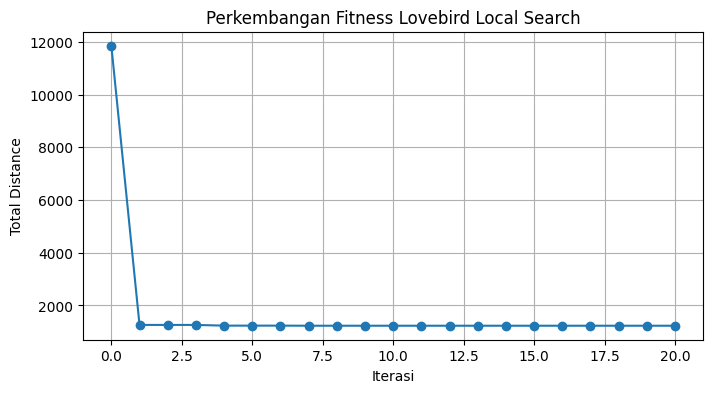

In [16]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(history, marker='o')
plt.title("Perkembangan Fitness Lovebird Local Search")
plt.xlabel("Iterasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

In [ ]:
# # Contoh penggunaan
# ortools = [21, 129, 30, 80, 130, 14, 63, 40, 97, 11, 66, 94, 141, 52, 120, 50, 3, 88, 51, 64, 132, 12, 43, 76, 112, 26, 137, 49, 118, 75, 90, 23, 115, 107, 47, 98, 10, 73, 122, 84, 29, 117, 55, 102, 121, 5, 56, 67, 33, 78, 131, 101, 124, 16, 60, 81, 18, 59, 37, 100, 46, 138, 1, 143]
# local_lovebird = [14, 130, 80, 30, 129, 21, 143, 1, 138, 46, 100, 37, 59, 81, 18, 141, 94, 52, 124, 16, 60, 101, 131, 78, 33, 67, 56, 5, 121, 102, 55, 117, 29, 84, 122, 73, 10, 98, 47, 107, 115, 23, 90, 120, 50, 75, 3, 118, 49, 137, 26, 112, 76, 43, 12, 132, 64, 51, 88, 66, 11, 97, 40, 63, 14]

# def tour_cost_float(tour):
#     s = 0.0
#     for k in range(len(tour)-1):
#         s += get_weight(tour[k], tour[k+1])
#     s += get_weight(tour[-1], tour[0])  # wrap
#     return s

# def tour_cost_int_scaled(tour, SCALE=1000):
#     s = 0
#     for k in range(len(tour)-1):
#         s += int(round(SCALE * get_weight(tour[k], tour[k+1])))
#     s += int(round(SCALE * get_weight(tour[-1], tour[0])))
#     return s / SCALE

# # --- contoh pakai rute yang sudah kamu punya:
# print("ORTools (float):", tour_cost_float(ortools))
# print("ORTools (int_scaled):", tour_cost_int_scaled(ortools, SCALE))

# print("Lovebird (float):", tour_cost_float(local_lovebird))
# print("Lovebird (int_scaled):", tour_cost_int_scaled(local_lovebird, SCALE))


# Iterated Lovebird

In [19]:
def double_bridge(route):
    L = len(route)
    if L < 8:
        return route[:]  # sama seperti semula
    rnd = random
    i1, i2, i3, i4 = sorted(rnd.sample(range(L), 4))
    segA = route[:i1]
    segB = route[i1:i2]
    segC = route[i2:i3]
    segD = route[i3:i4]
    segE = route[i4:]
    # varian klasik (tidak diubah)
    return segA + segC + segB + segD + segE


# --- 1) OR-Opt intra-route: pilih posisi sisip terbaik (circular, O(L)) ---
def or_opt_intra(route, k=2):
    L = len(route)
    if L < k + 2:
        return route[:]

    rnd = random
    Dm  = D
    ix  = idx

    # pilih blok [i..i+k-1] (tanpa wrap)
    i = rnd.randint(0, L - k - 1)
    a = route[i]
    b = route[i + k - 1]
    p = route[i - 1] if i > 0 else route[-1]
    n = route[i + k] if (i + k) < L else route[0]

    block    = route[i:i+k]
    residual = route[:i] + route[i+k:]
    M        = len(residual)

    # biaya pelepasan blok dari posisi lama (circular TSP)
    base_remove = -Dm[ix[p]][ix[a]] - Dm[ix[b]][ix[n]] + Dm[ix[p]][ix[n]]

    best_j = None
    best_delta = 0.0
    # sisip sebelum residual[j], j=0..M-1 mewakili sisi (x->y)
    for j in range(M):
        x = residual[j - 1] if j > 0 else residual[-1]
        y = residual[j]
        insert_cost = -Dm[ix[x]][ix[y]] + Dm[ix[x]][ix[a]] + Dm[ix[b]][ix[y]]
        delta = base_remove + insert_cost
        if delta < best_delta:
            best_delta = delta
            best_j = j

    if best_j is None:
        return route[:]  # tak ada perbaikan

    # sisipkan block di posisi terbaik
    new_route = residual[:best_j] + block + residual[best_j:]
    return new_route


def perturb_multi_simple(solution, p_intra=0.95, prefer_k3=False, max_block=6):
    # copy ringan per rute (tanpa deepcopy)
    sol = [r[:] for r in solution]
    rnd = random
    rrand = rnd.random

    # --- intra OR-Opt tetap ---
    if rrand() < p_intra:
        # pilih rute yang cukup panjang
        cand_idxs = [i for i, r in enumerate(sol) if len(r) >= 5]
        if cand_idxs:
            v = rnd.choice(cand_idxs)
            k = 3 if (prefer_k3 and len(sol[v]) >= 5) else 2
            sol[v] = or_opt_intra(sol[v], k=k)
    else:
        non_empty = [i for i, r in enumerate(sol) if len(r) > 0]
        if len(non_empty) >= 2:
            a, b = rnd.sample(non_empty, 2)
            ia = rnd.randrange(len(sol[a]))
            ib = rnd.randrange(len(sol[b]))
            sol[a][ia], sol[b][ib] = sol[b][ib], sol[a][ia]

    # --- strong shake: double-bridge HANYA saat stagnan ---
    if prefer_k3:
        # pilih rute terpanjang sekali saja
        v2 = max(range(len(sol)), key=lambda t: len(sol[t])) if sol else 0
        if len(sol[v2]) >= 8 and rrand() < 0.07:
            sol[v2] = double_bridge(sol[v2])

    # --- scramble kecil (5%) ---
    if rrand() < 0.05 and sol:
        v2 = max(range(len(sol)), key=lambda t: len(sol[t]))
        L = len(sol[v2])
        if L >= 6:
            m = rnd.randint(3, min(max_block, L - 1))
            i = rnd.randint(0, L - m)
            sub = sol[v2][i:i+m]
            rnd.shuffle(sub)
            sol[v2] = sol[v2][:i] + sub + sol[v2][i+m:]

    return sol

In [20]:
def iterated_lovebird(max_iter=30, local_gen=120, initial_solution=None, patience=3, seed=None,
                      budget_s=None):
    """
    Sama seperti ILS kamu, tapi menghormati batas waktu total (budget_s, detik).
    Waktu yang tersisa selalu diteruskan sebagai time_budget ke lovebird_local_search.
    """
    # --- RNG (tanpa ubah perilaku) ---
    if seed is not None:
        random.seed(seed)

    # alias lokal untuk lookup cepat
    ls = lovebird_local_search
    perturb = perturb_multi_simple

    # --- time budget helper ---
    SAFETY   = 0.05  # buffer biar gak mepet
    t_start  = time.perf_counter()
    deadline = (t_start + budget_s) if budget_s is not None else None

    def time_left():
        return None if deadline is None else max(0.0, deadline - time.perf_counter())

    # --- LS awal (hormati budget kalau ada) ---
    rem = time_left()
    if rem is not None and rem <= SAFETY:
        # waktu sangat sempit → kembalikan solusi awal cepat
        if initial_solution is not None:
            best_sol = [r[:] for r in initial_solution]
        else:
            ids_copy = ids[:]; random.shuffle(ids_copy)
            best_sol = [ids_copy]  # hanya satu kendaraan, jadi langsung satu list

        best_cost = sum(total_distance(r) for r in best_sol)
        return best_sol, best_cost, [best_cost]

    best_sol, best_cost, _ = ls(
        maxLoop=local_gen,
        initial_solution=initial_solution if initial_solution else None,
        time_budget=(rem - SAFETY) if rem is not None else None
    )
    history = [best_cost]

    no_improve = 0
    for _ in range(max_iter):
        # stop kalau waktu sisa mepet
        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        # adaptasi kekuatan perturbasi saat buntu (sama)
        prefer_k3 = (no_improve >= patience)
        max_block = 6 + 2 * (no_improve // patience)

        # perturb dari best (copy ringan di dalam fungsi)
        perturbed = perturb(
            best_sol,
            p_intra=0.9,
            prefer_k3=prefer_k3,
            max_block=max_block
        )

        # cek sisa waktu sebelum LS
        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        # local search pada hasil perturb (hormati budget)
        imp_sol, imp_cost, _ = ls(
            maxLoop=local_gen,
            initial_solution=perturbed,
            time_budget=(rem - SAFETY) if rem is not None else None
        )

        if imp_cost < best_cost - 1e-9:
            best_sol = [r[:] for r in imp_sol]  # salin ringan, jelas eksplisit
            best_cost = imp_cost
            no_improve = 0
        else:
            no_improve += 1

        # hard restart kecil bila buntu (hormati budget)
        if no_improve >= 2 * patience:
            # cek waktu cukup
            rem = time_left()
            if rem is None or rem > SAFETY + 0.1:
                strong = perturb(best_sol, p_intra=0.3, prefer_k3=True, max_block=12)

                rem = time_left()
                if rem is not None and rem <= SAFETY:
                    break

                best_sol2, best_cost2, _ = ls(
                    maxLoop=local_gen,
                    initial_solution=strong,
                    time_budget=(rem - SAFETY) if rem is not None else None
                )
                if best_cost2 < best_cost - 1e-9:
                    best_sol, best_cost = best_sol2, best_cost2
                    no_improve = 0

        history.append(best_cost)

    return best_sol, best_cost, history

In [21]:
# Contoh penggunaan lovebird_local_search
best_routes, best_cost, history = iterated_lovebird(max_iter=10, local_gen=11, patience=2, budget_s=40)
print("Total cost:", best_cost)
for i, route in enumerate(best_routes):
    print(f"Rute kendaraan {i+1}:", route)

Total cost: 1244.378988749645
Rute kendaraan 1: [54, 29, 63, 133, 95, 4, 42, 103, 11, 26, 111, 23, 107, 34, 72, 40, 106, 15, 93, 81, 37, 62, 132, 112, 96, 50, 129, 21, 124, 67, 123, 43, 101, 130, 1, 71, 55, 30, 115, 47, 88, 77, 20, 76, 60, 16, 85, 65, 7, 86, 22, 79, 35, 17, 56, 99, 9, 49, 94, 24, 105, 36, 91, 5, 97, 31, 83, 102, 14, 134, 57, 73, 122, 28, 87, 6, 108, 41, 116, 69, 38, 84, 8, 135, 53, 78, 18, 58, 128, 44, 121, 109, 118, 68, 33, 89, 13, 119, 75, 66, 74, 39, 104, 113, 64, 25, 120, 70, 12, 92, 32, 127, 2, 48, 98, 131, 100, 126, 61, 45, 19, 46, 114, 90, 3, 82, 125, 59, 27, 51, 80, 10, 117, 52, 110]


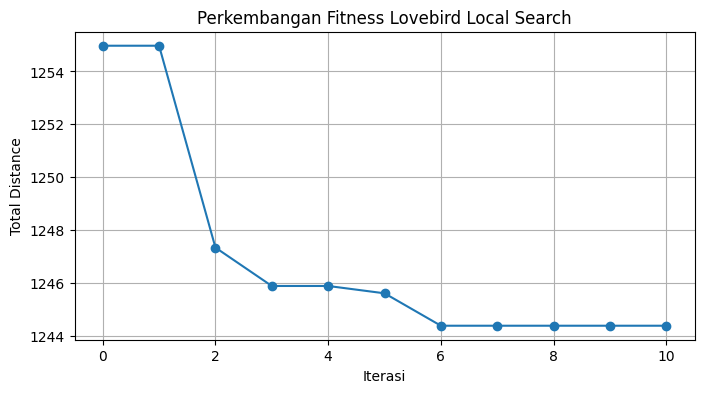

In [22]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(history, marker='o')
plt.title("Perkembangan Fitness Lovebird Local Search")
plt.xlabel("Iterasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

# Hyper Iterated Lovebird

In [23]:
def or_opt_k1_once(route):

    L = len(route)
    if L < 3:
        return route[:], 0.0, False

    Dm = D
    ix = idx
    EPS = 1e-12

    # Precompute index D untuk semua node di route (hemat lookup)
    r_ix = [ix[n] for n in route]

    best_delta = 0.0
    best_move  = None  # (i, y_idx_target) => sisip sebelum node di posisi y_idx_target (setelah pop)

    for i in range(L):
        a_idx = i
        a = route[a_idx]; ia = r_ix[a_idx]

        p_idx = a_idx - 1 if a_idx > 0 else L - 1
        n_idx = a_idx + 1 if (a_idx + 1) < L else 0

        ip = r_ix[p_idx]; inn = r_ix[n_idx]

        # Lepas a: (p->a, a->n) jadi (p->n)
        base_remove = -Dm[ip][ia] - Dm[ia][inn] + Dm[ip][inn]

        # 1) Cek semua sisi (x->y) dari tur asli KECUALI yang menyentuh a
        #    (yaitu j == a_idx-1 => (p->a) dan j == a_idx => (a->n))
        j = 0
        while j < L:
            if j != p_idx and j != a_idx:
                x_idx = j
                y_idx = j + 1 if (j + 1) < L else 0
                ix_x = r_ix[x_idx]; ix_y = r_ix[y_idx]

                insert_cost = -Dm[ix_x][ix_y] + Dm[ix_x][ia] + Dm[ia][ix_y]
                delta = base_remove + insert_cost
                if delta < best_delta - EPS:
                    # sisip sebelum 'y' di list SETELAH a di-pop
                    ins_pos = y_idx - (1 if y_idx > a_idx else 0)
                    best_delta = delta
                    best_move  = (a_idx, ins_pos)
            j += 1

        # 2) Tambahkan sisi (p->n) yang muncul setelah a dilepas
        #    (setara dengan sisip sebelum 'n' pada list setelah pop)
        insert_cost_pn = -Dm[ip][inn] + Dm[ip][ia] + Dm[ia][inn]
        delta_pn = base_remove + insert_cost_pn
        if delta_pn < best_delta - EPS:
            # sisip sebelum 'n' pada list SETELAH pop
            # posisi 'n' di list baru: jika n_idx > a_idx → n_idx-1, else n_idx
            ins_pos = n_idx - (1 if n_idx > a_idx else 0)
            best_delta = delta_pn
            best_move  = (a_idx, ins_pos)

    if best_move is None:
        return route[:], 0.0, False

    # Bangun rute baru sesuai best_move (pop + insert)
    i_pop, ins_pos = best_move
    new_route = route[:]             # salin ringan
    node = new_route.pop(i_pop)
    new_route.insert(ins_pos, node)
    return new_route, best_delta, True

In [24]:
def hyper_iterated_lovebird(
    max_iter=10,
    local_gen_shallow=8,
    local_gen_deep=30,
    deep_every=3,
    patience=2,
    initial_solution=None,
    p_intra=0.95,
    base_max_block=6,
    budget_s=None,
    seed=None
):
    if seed is not None:
        random.seed(seed)

    t_start = time.perf_counter()
    deadline = (t_start + budget_s) if budget_s is not None else None
    SAFETY = 0.05  # buffer biar gak mepet

    def time_left():
        if deadline is None:
            return None
        return max(0.0, deadline - time.perf_counter())

    # Start: LS agak dalam, tapi tetap hormati budget
    rem = time_left()
    if rem is not None and rem <= SAFETY:
        # waktu terlalu sempit; return solusi awal apa adanya
        if initial_solution is not None:
            best_sol = [r[:] for r in initial_solution]
        else:
            ids_copy = ids[:]; random.shuffle(ids_copy)
            best_sol = [ids_copy]  # hanya satu kendaraan, jadi langsung satu list

        best_cost = sum(total_distance(r) for r in best_sol)
        return best_sol, best_cost, [best_cost]

    sol0, cost0, _ = lovebird_local_search(
        maxLoop=max(local_gen_deep, 10),
        initial_solution=initial_solution,
        time_budget=(rem - SAFETY) if rem is not None else None
    )
    best_sol, best_cost = sol0, cost0
    history = [best_cost]
    no_improve = 0

    elite  = [(best_cost, [r[:] for r in best_sol])]  # (cost, sol)
    ELITE_K = 3                                       # simpan 3 terbaik

    for it in range(1, max_iter + 1):
        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break  # waktu habis aman

        # adaptasi kekuatan perturbasi saat buntu
        prefer_k3 = (no_improve >= patience)
        max_block = base_max_block + 2 * (no_improve // patience)

        # perturb dari best (ini cepat)
        perturbed = perturb_multi_simple(
            best_sol,
            p_intra=p_intra,
            prefer_k3=prefer_k3,
            max_block=max_block
        )

        # --- SIMILARITY GUARD (murah, O(n)) ---
        def _hamming_routes(A, B):
            diff = 0
            for ra, rb in zip(A, B):
                m = min(len(ra), len(rb))
                for i in range(m):
                    if ra[i] != rb[i]:
                        diff += 1
                diff += abs(len(ra) - len(rb))
            return diff

        # >>> PATCH 1: ambang adaptif berdasar ukuran tur
        total_n = sum(len(r) for r in best_sol)

        # fraksi target per fase
        BASE_FRAC  = 0.05   # baseline ~5% node
        EARLY_FRAC = 0.08   # 2 iterasi pertama sedikit lebih agresif
        MID_FRAC   = 0.08   # saat stagnan di tengah

        MIN_DIFF = max(8, int(BASE_FRAC * total_n))
        plateau_after = max(3, 2 * patience)   # kapan dianggap plateau di tengah

        diff = _hamming_routes(perturbed, best_sol)

        # pilih ambang sesuai fase
        need = MIN_DIFF
        if it <= 2:
            need = max(need, int(EARLY_FRAC * total_n))
        elif no_improve >= plateau_after:
            need = max(need, int(MID_FRAC * total_n))

        # satu kali re-perturb kalau masih terlalu mirip
        if diff < need:
            perturbed = perturb_multi_simple(
                best_sol,
                p_intra=max(0.6, p_intra - 0.2),  # sedikit lebih "kasar"
                prefer_k3=True,
                max_block=min(12, base_max_block + 2),
            )
        # <<< END PATCH 1

        # pilih kedalaman LS
        use_deep = (it % deep_every == 0) or (no_improve >= patience)
        depth = local_gen_deep if use_deep else local_gen_shallow

        # ---- time-slicing: bagi waktu tersisa ke iterasi yang belum jalan ----
        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        # --- pre-repair: 1 langkah OR-Opt k=1 per route (murah) ---
        for v in range(len(perturbed)):
            new_r, delta, ok = or_opt_k1_once(perturbed[v])
            if ok:
                perturbed[v] = new_r

        FINISHER_TAIL = 1.0   # sisakan ~1.0s buat finisher
        remaining_iter = max(1, max_iter - it + 1)

        # floor jatah per iterasi (biar gak kelaparan)
        MIN_BUDGET_SHALLOW = 0.50
        MIN_BUDGET_DEEP    = 1.25

        if rem is None:
            ls_budget = None
        else:
            usable = max(0.0, rem - max(SAFETY, FINISHER_TAIL))
            slot = usable / remaining_iter if remaining_iter > 0 else usable
            # bobot deep > shallow
            slot *= (1.6 if use_deep else 1.0)
            # terapkan floor
            floor_need = MIN_BUDGET_DEEP if use_deep else MIN_BUDGET_SHALLOW
            slot = max(slot, floor_need)
            # clamp agar tidak makan semua waktu
            ls_budget = max(0.0, min(slot, usable - 0.01))

        # jalankan LS dengan cap = jatah slot iterasi ini
        sol, cost, _ = lovebird_local_search(
            maxLoop=depth,
            initial_solution=perturbed,
            time_budget=ls_budget
        )

        # push kandidat ke pool (jaga unik by cost)
        if all(abs(cost - c0) > 1e-7 for c0, _ in elite):
            elite.append((cost, [r[:] for r in sol]))
            elite.sort(key=lambda x: x[0])
            if len(elite) > ELITE_K:
                elite.pop()  # buang yang terburuk

        # # --- OR-Opt k=1 finisher (≤ ~0.7 detik total) ---
        # rem = time_left()
        # budget_fin = (min(FINISHER_TAIL, max(0.0, rem - SAFETY)) if rem is not None else FINISHER_TAIL)
        # if budget_fin > 0.0:
        #     t_fin = time.perf_counter()
        #     improved_any = True
        #     while improved_any and (time.perf_counter() - t_fin) < budget_fin:
        #         improved_any = False
        #         for v in range(len(sol)):
        #             new_r, delta, ok = or_opt_k1_once(sol[v])
        #             if ok:
        #                 sol[v] = new_r
        #                 cost += delta
        #                 improved_any = True
        #                 # jika waktu hampir habis, keluar
        #                 if (time_left() is not None) and (time_left() <= SAFETY):
        #                     break
        #         if (time_left() is not None) and (time_left() <= SAFETY):
        #             break

        if cost < best_cost - 1e-9:
            best_sol, best_cost = sol, cost
            no_improve = 0
        else:
            no_improve += 1

            # Hard reheat hanya jika waktu cukup
            rem = time_left()
            if (no_improve >= 2 * patience) and (rem is None or rem > SAFETY + 0.1):
                strong = perturb_multi_simple(
                    best_sol,
                    p_intra=0.6,
                    prefer_k3=True,
                    max_block=min(12, base_max_block + 4)
                )
                rem = time_left()
                if rem is not None and rem <= SAFETY:
                    break
                sol2, cost2, _ = lovebird_local_search(
                    maxLoop=local_gen_deep,
                    initial_solution=strong,
                    time_budget=(rem - SAFETY) if rem is not None else None
                )
                if cost2 < best_cost - 1e-9:
                    best_sol, best_cost = sol2, cost2
                    no_improve = 0

        history.append(best_cost)

    return best_sol, best_cost, history

In [25]:
# def hyper_iterated_lovebird(
#     max_iter=10,
#     local_gen_shallow=6,
#     local_gen_deep=20,
#     num_vehicles=1,
#     initial_solution=None,
#     base_max_block=6,      # dipakai di perturb; boleh kamu kunci/uniform
#     budget_s=None,
#     seed=None
# ):
#     # RNG opsional
#     if seed is not None:
#         random.seed(seed)

#     # ---- timing minimal ----
#     t0 = time.perf_counter()
#     deadline = (t0 + budget_s) if budget_s is not None else None
#     SAFETY = 0.05

#     def time_left():
#         return None if deadline is None else max(0.0, deadline - time.perf_counter())

#     # ---- Iterasi 1: DEEP local search dari initial (atau random) ----
#     rem = time_left()
#     if rem is not None and rem <= SAFETY:
#         # waktu nyaris habis → kembalikan solusi awal apa adanya
#         if initial_solution is not None:
#             best_sol = [r[:] for r in initial_solution]
#         else:
#             ids_copy = ids[:]; random.shuffle(ids_copy)
#             best_sol = [ids_copy[i::num_vehicles] for i in range(num_vehicles)]
#         best_cost = sum(total_distance(r) for r in best_sol if len(r) >= 2)
#         return best_sol, best_cost, [best_cost]

#     sol, cost, _ = lovebird_local_search(
#         maxLoop=local_gen_deep,
#         num_vehicles=num_vehicles,
#         initial_solution=initial_solution,
#         time_budget=(time_left() - SAFETY) if time_left() is not None else None
#     )
#     best_sol, best_cost = [r[:] for r in sol], float(cost)
#     history = [best_cost]

#     # ---- Iterasi 2..max_iter: SHALLOW saja ----
#     for it in range(2, max_iter + 1):
#         rem = time_left()
#         if rem is not None and rem <= SAFETY:
#             break

#         strong = (it % 3 == 0)          # fix schedule (4 bisa kamu ubah)
#         perturbed = perturb_multi_simple(
#             best_sol,
#             p_intra=(0.95 if not strong else 0.80),  # sedikit kurang “rapi” saat strong
#             prefer_k3=strong,                         # aktifkan k=3 saat strong
#             max_block=(base_max_block if not strong else min(12, base_max_block + 4))
#         )

#         # Jalankan LS SHALLOW dengan sisa waktu
#         rem = time_left()
#         sol, cost, _ = lovebird_local_search(
#             maxLoop=local_gen_shallow,
#             num_vehicles=num_vehicles,
#             initial_solution=perturbed,
#             time_budget=(rem - SAFETY) if rem is not None else None
#         )

#         # Terima jika lebih baik
#         if cost < best_cost - 1e-12:
#             best_sol, best_cost = [r[:] for r in sol], float(cost)

#         history.append(best_cost)

#         # guard waktu minimal
#         if time_left() is not None and time_left() <= SAFETY:
#             break

#     return best_sol, best_cost, history

In [26]:
sol, cost, hist = hyper_iterated_lovebird(
    max_iter=30,            # total iter ILS
    local_gen_shallow=10,    # LS ringan
    local_gen_deep=18,      # LS lebih dalam
    deep_every=4,           # tiap 4 iter sekali deep
    patience=1,             # adapt cepat saat buntu
    p_intra=0.95,           # or-opt intra 98%
    base_max_block=6,
    budget_s=40
)
print("Total cost:", cost)
for i, route in enumerate(sol):
    print(f"Rute kendaraan {i+1}:", route)

Total cost: 1216.6093402258173
Rute kendaraan 1: [81, 37, 96, 112, 132, 62, 93, 15, 106, 110, 54, 29, 52, 117, 10, 80, 51, 27, 59, 125, 82, 3, 90, 114, 46, 45, 61, 126, 100, 131, 98, 48, 127, 32, 92, 12, 70, 120, 25, 64, 113, 104, 39, 74, 66, 2, 75, 119, 13, 89, 33, 68, 118, 19, 121, 44, 128, 58, 18, 78, 38, 53, 135, 8, 84, 69, 116, 41, 108, 6, 87, 122, 28, 109, 73, 57, 134, 14, 102, 83, 31, 97, 5, 91, 36, 105, 24, 94, 49, 9, 99, 56, 17, 35, 79, 22, 86, 7, 65, 85, 16, 60, 20, 77, 88, 76, 47, 115, 30, 55, 71, 1, 130, 101, 50, 43, 123, 67, 129, 21, 124, 26, 11, 103, 42, 4, 95, 133, 111, 63, 23, 107, 34, 72, 40]


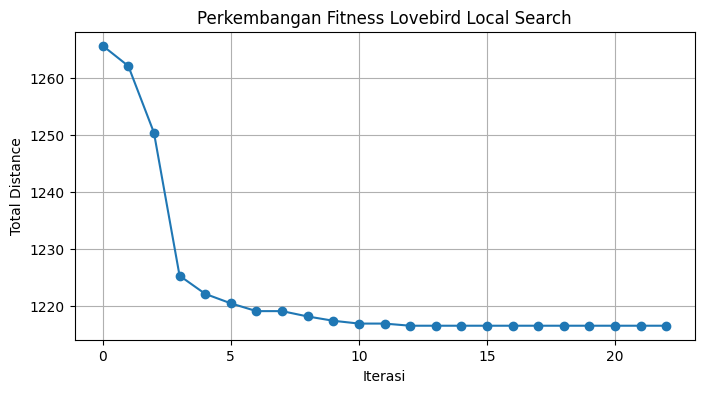

In [27]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(hist, marker='o')
plt.title("Perkembangan Fitness Lovebird Local Search")
plt.xlabel("Iterasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

# Testing

In [ ]:
def timed_call(fn, *args, **kwargs):
    t0 = time.perf_counter()
    # sol, cost, hist = fn(*args, **kwargs)
    ret = fn(*args, **kwargs)
    dt = time.perf_counter() - t0
    # return sol, cost, hist, dt

    # Normalisasi return value ke (sol, cost, hist)
    if not isinstance(ret, tuple):
        raise ValueError("Solver must return a tuple.")

    if len(ret) == 2:
        sol, cost = ret
        hist = None
    elif len(ret) == 3:
        sol, cost, hist = ret
    elif len(ret) == 4:
        sol, cost, hist_c, hist_t = ret
        # satukan jadi satu objek history
        hist = {"cost": hist_c, "time": hist_t}
    else:
        raise ValueError(f"Unexpected solver return length: {len(ret)}")

    return sol, cost, hist, dt

def experiment_boxplot_time(N=20):
    # results_ort, times_ort = [], []
    # results_ils, times_ils = [], []
    results_hil, times_hil = [], []

    for _ in range(N):
        # # OR-Tools (pakai solve_vrp milikmu, TANPA diubah)
        # _, c1, _, t1 = timed_call(solve_vrp, num_vehicles=1, timeout_s=40)
        # results_ort.append(c1); times_ort.append(t1)

        # # ILS (versi lama tanpa budget)
        # _, c2, _, t2 = timed_call(iterated_lovebird,
        #                           max_iter=10, local_gen=10, num_vehicles=1, patience=1, budget_s=40)
        # results_ils.append(c2); times_ils.append(t2)

        # Hyper-ILS (dengan budget)
        _, c3, _, t3 = timed_call(hyper_iterated_lovebird,
                                  max_iter=30,
                                  local_gen_shallow=4, local_gen_deep=15,
                                  deep_every=4, patience=1,
                                  p_intra=0.99, base_max_block=6,
                                  budget_s=40, seed=None)
        results_hil.append(c3); times_hil.append(t3)

    def stat(x): 
        x = np.array(x, float); 
        return np.mean(x), np.std(x, ddof=1), np.median(x), np.min(x), np.max(x)

    # m1, s1, med1, mn1, mx1 = stat(results_ort)
    # m2, s2, med2, mn2, mx2 = stat(results_ils)
    m3, s3, med3, mn3, mx3 = stat(results_hil)

    # tm1, ts1, _, _, _ = stat(times_ort)
    # tm2, ts2, _, _, _ = stat(times_ils)
    tm3, ts3, _, _, _ = stat(times_hil)

    print("\n=== RINGKASAN COST & WAKTU (mean±std; median; min–max) ===")
    # print(f"LS        : cost {m1:.2f}±{s1:.2f} (med {med1:.2f}) [{mn1:.2f}, {mx1:.2f}] | time {tm1:.2f}±{ts1:.2f}s")
    # print(f"ILS       : cost {m2:.2f}±{s2:.2f} (med {med2:.2f}) [{mn2:.2f}, {mx2:.2f}] | time {tm2:.2f}±{ts2:.2f}s")
    print(f"Hyper-ILS : cost {m3:.2f}±{s3:.2f} (med {med3:.2f}) [{mn3:.2f}, {mx3:.2f}] | time {tm3:.2f}±{ts3:.2f}s")

    return (
        # results_ort,
        # results_ils, 
        results_hil
        ), (
            # times_ort,
            # times_ils, 
            times_hil
            )

# # contoh pemanggilan
# (
#     # results_ort, 
#     # results_ils, 
#     results_hil
#     ), (
#         # times_ort, 
#         # times_ils, 
#         times_hil
#         ) = experiment_boxplot_time(N=20)

In [29]:
# (costs_lb, costs_k2), (times_lb, times_k2) = experiment_compare_locals(
#     N=20,
#     budget_s=40,
#     num_vehicles=1,
#     base_seed=42,
#     lb_maxLoop=20,
#     kopt_k=2,
#     kopt_maxLoop=20
# )

In [30]:
# # --- Boxplot ---
# plt.figure(figsize=(6,6))
# plt.boxplot([results_hil], labels=["Hyper-ILS"])
# plt.ylabel("Total Distance (lower = better)")
# plt.title(f"Perbandingan Hasil {N} Run")
# plt.show()

In [31]:
# # --- Boxplot ---
# plt.figure(figsize=(6,6))
# plt.boxplot([times_ort, times_ils, times_hil], labels=["OR Tools", "ILS", "Hyper-ILS"])
# plt.ylabel("Total Distance (lower = better)")
# plt.title(f"Perbandingan Hasil {N} Run")
# plt.show()

In [32]:
# def describe_simple(res_ort, res_hil, t_ort, t_hil, name_a="OR-Tools", name_b="Hyper-ILS"):
#     import numpy as np
#     a  = np.array(res_ort, float)   # cost OR-Tools
#     b  = np.array(res_hil, float)   # cost Hyper-ILS
#     ta = np.array(t_ort, float)     # time OR-Tools
#     tb = np.array(t_hil, float)     # time Hyper-ILS
#     assert len(a) == len(b) == len(ta) == len(tb), "Panjang hasil tidak sama"

#     n = len(a)
#     d  = a - b            # + => Hyper-ILS lebih baik (cost lebih kecil)
#     dt = ta - tb          # + => OR-Tools lebih lama

#     # ringkas
#     win_b  = int(np.sum(d > 0))
#     win_a  = int(np.sum(d < 0))
#     ties   = int(np.sum(d == 0))

#     # persen improvement relatif OR-Tools (hindari /0)
#     safe = np.where(a != 0, a, np.nan)
#     pct_improve = 100 * (d / safe)

#     print("\n=== DESKRIPSI SINGKAT: OR-Tools vs Hyper-ILS ===")
#     print(f"n runs                         : {n}")
#     print(f"{name_b} win-rate (lebih kecil) : {win_b}/{n} = {win_b/n:.3f}")
#     print(f"{name_a} win-rate              : {win_a}/{n} = {win_a/n:.3f}")
#     print(f"Ties                           : {ties}")

#     print(f"\nΔcost = {name_a} - {name_b}   : mean {np.nanmean(d):.2f} | median {np.nanmedian(d):.2f} | "
#           f"min {np.nanmin(d):.2f} | max {np.nanmax(d):.2f}  (+ => {name_b} lebih baik)")

#     print(f"% improvement (rel. {name_a}) : mean {np.nanmean(pct_improve):.3f}% | "
#           f"median {np.nanmedian(pct_improve):.3f}%")

#     print(f"\nRata-rata waktu               : {name_a} {np.mean(ta):.2f}s ± {np.std(ta, ddof=1):.2f}s | "
#           f"{name_b} {np.mean(tb):.2f}s ± {np.std(tb, ddof=1):.2f}s")
#     print(f"Δtime = {name_a} - {name_b}   : mean {np.mean(dt):.2f}s ( + => {name_a} lebih lama )")

#     print(f"\nBest {name_a}                 : {np.min(a):.2f} (run #{int(np.argmin(a))+1})")
#     print(f"Best {name_b}                 : {np.min(b):.2f} (run #{int(np.argmin(b))+1})")


In [33]:
# describe_simple(results_ort, results_hil, times_ort, times_hil)

In [34]:
# describe_simple(results_ils, results_hil, times_ils, times_hil)

In [35]:
def experiment_convergence_hyper(
    N=20,
    cfg=None,
    budget_s=40,
    base_seed=42,
    overlay=True,          # True: satu plot overlay; False: small-multiples
    grid_max_cols=5,       # utk small-multiples
):
    """
    Jalankan Hyper-ILS N kali, simpan history tiap run, dan plot konvergensinya.
    Tidak mengubah algoritma; hanya instrumentation.
    """
    if cfg is None:
        cfg = dict(
            max_iter=30,
            local_gen_shallow=4,
            local_gen_deep=15,
            deep_every=4,
            patience=1,
            p_intra=0.99,
            base_max_block=6,
        )

    all_hists = []
    runs = []  # list of dict ringkasan per-run

    for r in range(N):
        seed = base_seed + 10*r
        sol, cost, hist, dt = timed_call(
            hyper_iterated_lovebird,
            budget_s=budget_s,
            seed=seed,
            **cfg
        )
        if hist is None:
            hist = []

        # metrik-metrik kecil untuk insight cepat
        if len(hist) > 0:
            best_val = min(hist)
            best_it  = int(min(range(len(hist)), key=lambda i: hist[i]))
        else:
            best_val, best_it = float('inf'), -1

        print(f"run#{r+1:02d} seed={seed} | final={cost:.2f} "
              f"| best_hist={best_val if best_val!=float('inf') else float('nan'):.2f} "
              f"(it={best_it}) | hist_len={len(hist)} | time={dt:.2f}s")

        runs.append({
            "run": r+1,
            "seed": seed,
            "final_cost": float(cost),
            "time_s": float(dt),
            "hist_len": int(len(hist)),
            "best_hist": float(best_val if best_val!=float('inf') else cost),
            "best_it": int(best_it),
        })
        all_hists.append(hist)

    # ==== Plot konvergensi ====
    if overlay or N > 16:
        plt.figure(figsize=(8, 5))
        for r, hist in enumerate(all_hists, 1):
            if len(hist) == 0: 
                continue
            plt.plot(range(len(hist)), hist, lw=1.0, alpha=0.6)
        plt.xlabel("Iterasi")
        plt.ylabel("Best-so-far cost")
        plt.title(f"Hyper-ILS Convergence (N={N}, overlay)")
        plt.grid(alpha=0.25)
        plt.tight_layout()
        plt.show()
    else:
        cols = min(grid_max_cols, N)
        rows = math.ceil(N / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(3.4*cols, 2.6*rows), squeeze=False)
        ax_flat = axes.ravel()
        for i in range(N):
            ax = ax_flat[i]
            hist = all_hists[i]
            if len(hist) > 0:
                ax.plot(range(len(hist)), hist, lw=1.1)
                ax.set_title(f"run#{i+1}")
                ax.set_xlabel("Iterasi")
                ax.set_ylabel("Cost")
                ax.grid(alpha=0.25)
            else:
                ax.set_title(f"run#{i+1} (no hist)")
                ax.axis("off")
        # matikan sisa subplot kalau ada
        for j in range(N, len(ax_flat)):
            ax_flat[j].axis("off")
        fig.suptitle(f"Hyper-ILS Convergence (N={N}, small-multiples)", y=1.02)
        plt.tight_layout()
        plt.show()

    # ==== Ringkasan akhir sederhana ====
    finals = [r["final_cost"] for r in runs]
    times  = [r["time_s"] for r in runs]
    print("\n--- Ringkasan Performa ---")
    print(f"final: mean={np.mean(finals):.2f}  std={np.std(finals, ddof=1):.2f}  "
          f"median={np.median(finals):.2f}  min={np.min(finals):.2f}  max={np.max(finals):.2f}")
    print(f"time : mean={np.mean(times):.2f}s std={np.std(times, ddof=1):.2f}s")

    # kembalikan kalau mau dipakai analisis lanjut
    return runs, all_hists

In [36]:
cfg = dict(
    max_iter=100,
    local_gen_shallow=6,
    local_gen_deep=15,
    deep_every=3,
    patience=1,
    p_intra=0.99,
    base_max_block=8
)

runs, all_hists = experiment_convergence_hyper(
    N=20,
    cfg=cfg,
    budget_s=40,
    base_seed=42,
    overlay=True   # set False kalau mau small-multiples (<=16 run enak dilihat)
)

run#01 seed=42 | final=1216.61 | best_hist=1216.61 (it=29) | hist_len=35 | time=39.95s
run#02 seed=52 | final=1220.75 | best_hist=1220.75 (it=16) | hist_len=24 | time=39.95s
run#03 seed=62 | final=1223.72 | best_hist=1223.72 (it=17) | hist_len=21 | time=39.97s
run#04 seed=72 | final=1247.26 | best_hist=1247.26 (it=9) | hist_len=17 | time=39.95s
run#05 seed=82 | final=1216.75 | best_hist=1216.75 (it=8) | hist_len=15 | time=39.95s
run#06 seed=92 | final=1216.61 | best_hist=1216.61 (it=25) | hist_len=35 | time=39.95s
run#07 seed=102 | final=1217.09 | best_hist=1217.09 (it=9) | hist_len=30 | time=39.95s
run#08 seed=112 | final=1220.47 | best_hist=1220.47 (it=8) | hist_len=24 | time=39.95s
run#09 seed=122 | final=1216.75 | best_hist=1216.75 (it=15) | hist_len=27 | time=39.95s
run#10 seed=132 | final=1216.61 | best_hist=1216.61 (it=27) | hist_len=30 | time=39.95s


KeyboardInterrupt: 

# Tuning

In [ ]:
# ---------------------------------------------------------
# UTIL
# ---------------------------------------------------------
def cvar20(costs):
    k = max(1, int(0.2*len(costs)))
    return float(np.sort(costs)[:k].mean())

# di eval_config_hils: return juga "cvar20"

def timed_call(fn, *args, **kwargs):
    t0 = time.perf_counter()
    sol, cost, hist = fn(*args, **kwargs)
    dt = time.perf_counter() - t0
    return sol, cost, hist, dt

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

def tour_cost(route):
    if not route: return 0.0
    s = 0.0
    for i in range(len(route) - 1):
        s += D[idx[route[i]]][idx[route[i+1]]]
    s += D[idx[route[-1]]][idx[route[0]]]
    return s

def multi_tour_cost(routes):
    return sum(tour_cost(r) for r in routes if len(r) >= 2)

# ---------------------------------------------------------
# EVALUATOR: jalankan beberapa replika utk 1 konfigurasi
# ---------------------------------------------------------
def eval_config_hils(cfg, replicates=5, base_seed=12345,
                     budget_s=12, verbose=False):
    """
    Return ringkasan + detail per-replicate:
      - all_costs, all_times
      - replicates: list of dict {run, seed, cost, time}
      - statistik ringkas (mean, median, q1, q3, std, cvar20, dst.)
    """
    seeds = [base_seed + 1000*r for r in range(replicates)]  # CRN: seed konsisten
    costs, times, reps = [], [], []

    for r in range(replicates):
        _, cost, _, dt = timed_call(
            hyper_iterated_lovebird,
            max_iter=cfg["max_iter"],
            local_gen_shallow=cfg["local_gen_shallow"],
            local_gen_deep=cfg["local_gen_deep"],
            deep_every=cfg["deep_every"],
            patience=cfg["patience"],
            p_intra=cfg["p_intra"],
            base_max_block=cfg["base_max_block"],
            num_vehicles=num_vehicles,
            budget_s=budget_s,
            seed=seeds[r],
        )
        costs.append(cost)
        times.append(dt)
        reps.append({"run": r+1, "seed": seeds[r], "cost": float(cost), "time": float(dt)})
        if verbose:
            print(f"    replicate#{r+1} seed={seeds[r]}: cost={cost:.2f}, time={dt:.2f}s")

    arr  = np.array(costs, float)
    tarr = np.array(times, float)

    # statistik ringkas
    q1, q3 = np.percentile(arr, 25), np.percentile(arr, 75)
    out = {
        "cfg": cfg.copy(),
        "runs": replicates,
        "all_costs": [float(x) for x in arr.tolist()],
        "all_times": [float(x) for x in tarr.tolist()],
        "replicates": reps,                       # <— detail per replicate
        "best": float(arr.min()),
        "median": float(np.median(arr)),
        "mean": float(arr.mean()),
        "std": float(arr.std(ddof=1)) if replicates > 1 else 0.0,     # <— tambah std (buat ranking print)
        "q1": float(q1), "q3": float(q3),
        "cvar20": float(cvar20(arr)),                                   # <— CVaR20
        "t_mean": float(tarr.mean()),
        "t_std": float(tarr.std(ddof=1)) if replicates > 1 else 0.0,    # opsional, buat info waktu
    }
    return out

# ---------------------------------------------------------
# SAMPLER: random search di ruang parameter
# ---------------------------------------------------------
def sample_space():
    """Satu sampel konfigurasi Hyper-ILS.
       Jaga agar tidak berat tapi masih eksploratif."""
    return {
        "max_iter": random.choice([30]),           # budget akan membatasi totalnya
        "local_gen_shallow": random.choice([4, 5]),
        "local_gen_deep"   : random.choice([11, 13, 15]),
        "deep_every"       : random.choice([3, 4, 5]),
        "patience"         : random.choice([1, 2]),
        "p_intra"          : random.choice([0.95, 0.97, 0.98, 0.99]),
        "base_max_block"   : random.choice([6, 8, 10]),
    }

# ---------------------------------------------------------
# REFINER: generasi tetangga di sekitar config terbaik
# ---------------------------------------------------------
def neighbors(cfg):
    def clamp(x, lo, hi): 
        return max(lo, min(hi, x))

    ints = {}
    # ints["max_iter"] = sorted(set([clamp(cfg["max_iter"]+d, 8, 16) for d in [-2, -1, 0, +1, +2]]))
    ints["local_gen_shallow"] = sorted(set([clamp(cfg["local_gen_shallow"]+d, 3, 6) for d in [-1, 0, +1]]))
    ints["local_gen_deep"]    = sorted(set([clamp(cfg["local_gen_deep"]+d, 10, 16) for d in [-2, -1, 0, +1, +2]]))
    ints["deep_every"]        = sorted(set([clamp(cfg["deep_every"]+d, 2, 6) for d in [-1, 0, +1]]))
    ints["patience"]          = sorted(set([clamp(cfg["patience"]+d, 1, 3) for d in [-1, 0, +1]]))
    ints["base_max_block"]    = sorted(set([clamp(cfg["base_max_block"]+d, 4, 12) for d in [-2, 0, +2]]))

    ints["max_iter"] = sorted(set([clamp(cfg["max_iter"]+d, 30, 30) for d in [0]]))
    # ints["local_gen_shallow"] = sorted(set([clamp(cfg["local_gen_shallow"]+d, 3, 9) for d in [0]]))
    # ints["local_gen_deep"]    = sorted(set([clamp(cfg["local_gen_deep"]+d, 14, 26) for d in [0]]))
    # ints["deep_every"]        = sorted(set([clamp(cfg["deep_every"]+d, 2, 6) for d in [0]]))
    # ints["patience"]          = sorted(set([clamp(cfg["patience"]+d, 1, 3) for d in [0]]))
    # ints["base_max_block"]    = sorted(set([clamp(cfg["base_max_block"]+d, 4, 12) for d in [0]]))

    fp = sorted(set([round(x,3) for x in [
        cfg["p_intra"]-0.02, cfg["p_intra"]-0.01, cfg["p_intra"],
        cfg["p_intra"]+0.01, cfg["p_intra"]+0.02
    ] if 0.90 <= x <= 0.995]))

    # fp = sorted(set([round(x,3) for x in [
    #     cfg["p_intra"]
    # ] if 0.90 <= x <= 0.995]))

    neighs = []
    for mi in ints["max_iter"]:
        for lgs in ints["local_gen_shallow"]:
            for lgd in ints["local_gen_deep"]:
                for de in ints["deep_every"]:
                    for pa in ints["patience"]:
                        for pi in fp:
                            for bm in ints["base_max_block"]:
                                neighs.append({
                                    "max_iter": mi,
                                    "local_gen_shallow": lgs,
                                    "local_gen_deep": lgd,
                                    "deep_every": de,
                                    "patience": pa,
                                    "p_intra": float(pi),
                                    "base_max_block": bm
                                })
    # opsi: shuffle & subset biar nggak kebanyakan
    random.shuffle(neighs)
    return neighs[:40]  # batasi 40 kandidat terdekat

# ---------------------------------------------------------
# TUNER: random search + refine
# ---------------------------------------------------------
def tune_hyper_ils(
    trials_random=60,     # jumlah sampel random
    trials_refine=40,     # kandidat refine (dibatasi di neighbors())
    replicates=5,         # run per konfigurasi
    target_best=2012.0,   # stop dini jika sudah <= target
    budget_s=12,
    base_seed=12345,
    verbose=False
):
    all_results = []

    # ---- Phase 1: Random Search ----
    for t in range(trials_random):
        cfg = sample_space()
        res = eval_config_hils(cfg, replicates=replicates, base_seed=base_seed,
                               budget_s=budget_s, num_vehicles=num_vehicles, verbose=verbose)
        all_results.append(res)
        print(f"[RS {t+1}/{trials_random}] best={res['best']:.2f}  med={res['median']:.2f}  "
              f"time~{res['t_mean']:.2f}s  cfg={res['cfg']}")
        print("      costs :", ", ".join(f"{x:.2f}" for x in res["all_costs"]))
        print("      times :", ", ".join(f"{x:.2f}s" for x in res["all_times"]))
        if res["best"] <= target_best:
            print("Target tercapai pada random search.")
            break

    # pilih kandidat terbaik dari fase 1 (berdasar 'best', tie-break median)
    all_results.sort(key=lambda r: (r["best"], r["median"]))
    top = all_results[0]
    print("\n[Top setelah Random Search]")
    print(f"best={top['best']:.2f}  median={top['median']:.2f}  "
          f"time~{top['t_mean']:.2f}s cfg={top['cfg']}")

    # ---- Phase 2: Refine sekitar kandidat terbaik ----
    neighs = neighbors(top["cfg"])[:trials_refine]
    for t, cfg in enumerate(neighs, 1):
        res = eval_config_hils(cfg, replicates=replicates, base_seed=base_seed,
                               budget_s=budget_s, num_vehicles=num_vehicles, verbose=False)
        all_results.append(res)
        print(f"[RF {t}/{len(neighs)}] best={res['best']:.2f}  med={res['median']:.2f}  "
              f"time~{res['t_mean']:.2f}s  cfg={res['cfg']}")
        print("      costs :", ", ".join(f"{x:.2f}" for x in res["all_costs"]))
        print("      times :", ", ".join(f"{x:.2f}s" for x in res["all_times"]))

        for rep in res["replicates"]:
            print(f"        r{rep['run']:02d} seed={rep['seed']}: cost={rep['cost']:.2f} | {rep['time']:.2f}s")

        if res["best"] <= target_best:
            print("Target tercapai pada refine.")
            break

    # ---- Final ranking ----
    all_results.sort(key=lambda r: (r["best"], r["median"]))
    print("\n=== TOP 10 by Best (then Median) ===")
    for i, r in enumerate(all_results[:10], 1):
        print(f"{i:2d}) best={r['best']:.2f}  med={r['median']:.2f}  "
      f"cvar20={r['cvar20']:.2f}  mean={r['mean']:.2f}±{r['std']:.2f}  "
      f"time~{r['t_mean']:.2f}s  cfg={r['cfg']}")

    return all_results

In [ ]:
# tetapkan budget & num_vehicles tetap
ALL = tune_hyper_ils(
    trials_random=60,     # kamu bisa mulai di 40 dulu kalau mau cepat
    trials_refine=40,
    replicates=5,         # 3–5 cukup; 5 lebih stabil
    target_best=2009,   # stop dini jika sudah kena target
    budget_s=40,          # JANGAN ubah
    base_seed=42,         # biar reproducible
    verbose=False
)

[RS 1/60] best=2017.79  med=2024.12  time~39.96s  cfg={'max_iter': 30, 'local_gen_shallow': 5, 'local_gen_deep': 15, 'deep_every': 5, 'patience': 1, 'p_intra': 0.95, 'base_max_block': 10}
      costs : 2024.12, 2017.79, 2028.14, 2040.80, 2021.74
      times : 39.95s, 39.95s, 39.96s, 39.95s, 39.96s
[RS 2/60] best=2008.99  med=2021.24  time~39.96s  cfg={'max_iter': 30, 'local_gen_shallow': 5, 'local_gen_deep': 11, 'deep_every': 3, 'patience': 1, 'p_intra': 0.99, 'base_max_block': 8}
      costs : 2026.89, 2017.79, 2021.24, 2025.68, 2008.99
      times : 39.96s, 39.96s, 39.96s, 39.96s, 39.95s
Target tercapai pada random search.

[Top setelah Random Search]
best=2008.99  median=2021.24  time~39.96s cfg={'max_iter': 30, 'local_gen_shallow': 5, 'local_gen_deep': 11, 'deep_every': 3, 'patience': 1, 'p_intra': 0.99, 'base_max_block': 8}
[RF 1/40] best=2014.03  med=2016.93  time~39.95s  cfg={'max_iter': 30, 'local_gen_shallow': 4, 'local_gen_deep': 10, 'deep_every': 3, 'patience': 1, 'p_intra':

In [ ]:
# # Ambil entry terbaik (urutkan by 'best', tie-break 'median')
# best_entry = sorted(ALL, key=lambda r: (r["best"], r["median"]))[0]

# print("\n=== BEST CONFIG OVERALL ===")
# print("Config :", best_entry["cfg"])
# print("Best   :", best_entry["best"])
# print("Median :", best_entry["median"])
# print("Time ~ :", best_entry["t_mean"], "s (avg)")

# routes = best_entry["best_sol"]   # <-- inilah rutenya (list of routes)
# print("\n=== ROUTES (best over all trials) ===")
# total = 0.0
# for v, r in enumerate(routes, 1):
#     c = tour_cost(r)
#     total += c
#     print(f"Vehicle {v}: len={len(r)}, cost={c:.2f}")
#     print("  Route :", r)
# print(f"TOTAL COST (recomputed) = {total:.2f}")
